# CS387 Project
# Volleyball Action Recogntion
Author: Jake Kougan

Welcome! This notebook is dedicated to the training of neural networks with the goal of classifiying the action taking place in the images. This notebook will feature action recognition via two different neural architectures. The first being simple image classification using the ResNet50 model loaded from torchvision. The second model will be a pose detection model. At the end of all the testing we will discover which one performs better. Though i hypothesize that pose estimation model will do better.


# Data Preparation

Before we get into the training, we need to do alot of preparation to get our notebook and data ready to be passed into the neural network.

1. First We need to import an abusrd amount of python libraries
2. Create a gpu device to store our models and tensors
3. Given that we are working with very large and high quality images we will need to find the mean and standard deviation of the resized image data to be able to eventually perform normalization to standardize them.
4. load iamages and labels and create a custom dataset to pass into the models
5. Download the models and modify them to fit our task
6. Test the model prior to training, analyze results, then train the model with our data to evaluate its performance




In [2]:
#Importing Numerous libraries
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
import time
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
from PIL import Image
import torchvision.datasets as data
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader 
import os
import csv
import pandas as pd
import cv2


/home/exouser/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set device to point to a GPU if we have one, CPU otherwise.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
#need to get the means and standard devs for normalization
#WARNING! This will take awhile
def get_mean_STD():
    path_data = "DATA"
    files = os.listdir(path_data)
    new_size = (224, 224)
    X = []
    for file in files:
        image_path = os.path.join(path_data, file)
        if os.path.isfile(image_path) == True:
            img = Image.open(image_path)
            img_modif = img.resize(new_size)
            np_img = np.array(img_modif)
            X.append(np_img)
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    return mean, std
    

stuff =get_mean_STD()

In [16]:
#transpose and flatten the means and stds so they're compatible with our input data
mean = stuff[0].transpose()
std = stuff[1].transpose()
mean_flat = np.squeeze(mean)
std_flat = np.squeeze(std)



In [17]:
#retrieving the labels for csv file mapping
def get_labels():
    #label_encoder = LabelEncoder()
    classes = ["attack", "block", "serve", "pass", "set"]
    labels = []
    labels_eng = []
    path = "DATA"
    for file in os.listdir(path):
        image_path = os.path.join(path, file)
        if os.path.isfile(image_path) == True:
            file = file.split()
            for name in file:
                if name == "attack":
                    labels.append(0)
                elif name == "block":
                    labels.append(1)
                elif name == "serve":
                    labels.append(2)
                elif name == "pass":
                    labels.append(4)
                elif name == "set":
                    labels.append(3)   

    #labels = torch.tensor(labels, dtype =torch.long)
    return labels
        

labels = get_labels()
            
            

In [18]:
#We will use this dataframe to ensure each image has the correct labeling
hellp = pd.read_csv("Labels.csv")
hellp = hellp.head(777)
convert_dict = {'Labels': int}
df = hellp.astype(convert_dict)
df


,Images,Labels
0,serve (58).jpg,2
1,attack (137).jpg,0
2,attack (206).JPG,0
3,set (10).PNG,3
4,pass (68).jpg,4
...,...,...
772,serve (13).jpg,2
773,serve (35).jpg,1
774,block (80).jpg,0
775,attack (135).jpg,0


# Creating a Custom Dataset:

Here we will be creating our custom data set that inherits from the dataset class. This will allows us to modify the data to fit the model and make sure that each label is matched to an image so backprop can be performed and weights can be updated. As far as how our input data will be manipulted, assuming the transform perameter is not set to None, prior to being loaded into the dataset the images will be resized to (224, 224) as these are the dimensions ResNet expects. We will also converted the image data to floats for more precise calculations, and normalizing the data to standardize it so the model doesn't throw a fit. Both images and labels we be returned in a tuple format.

In [19]:
#taken from documentation https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

#Creating a custom data set that inherits from the dataset class where we prepare the data for training 

import pandas as pd
from torchvision.io import read_image

class VballImage(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self._img_labels = annotations_file
        self._img_dir = img_dir
        self._files = os.listdir(self._img_dir)
        self._files = [file for file in self._files if os.path.isfile(os.path.join(self._img_dir, file)) == True]
        
        #idea for using transforms.Compose from codehelp
        #I had to perform numerous transformations to the input data so the images could work with the model
        self._transform = torchvision.transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ConvertImageDtype(torch.float),
            transforms.Normalize(mean_flat, std_flat)])
        self._target_transform = target_transform
        self.classes = [0, 1, 2, 3, 4]
        
    def __len__(self):
        return len(self._img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self._img_dir, self._files[idx])
       
        image = read_image(img_path)
        label = self._img_labels.iloc[idx, 1]
        if self._transform:
            image = self._transform(image)
        if self._target_transform:
            label = self._target_transform(label)
        return image, label

In [20]:
#Just a way to remind myself which label goes with what class
labels_map = {
    0 : "attack",
    1 : "block",
    2 : "serve",
    3 : "set",
    4 : "pass",
}



In [21]:
#dataset instance
dataSET = VballImage(df, "DATA", torchvision.transforms.Compose)
dataSET

In [22]:
#Creating the data loaders that will be passed into the models
dataloader = DataLoader(dataSET, batch_size=12, shuffle=True)
dataloader2 = DataLoader(dataSET, batch_size=24, shuffle=True)



# Helper Functions:
To train and better understand our data and result we are going to need to pull rely on helper functions we have seen in previous assignments.

test_model: will be ran before and affter the training of each of our models and will evaluate the models accuracy at recognizing each of our 5 classes as well as of all classes on average.

train_model: will be used to pass the images and labels onto the model so it can go through forward prop and begin to learn during backprop. Will only be called once per model and also takes the number of epochs the model will train for

Stat class: will keep track of all our metrics when training and evaluating the models 

In [23]:
#Test model function provided by Mark Liffiton
def test_model(model, dataloader):
    classes = dataloader.dataset.classes
    class_correct = {clsname: 0 for clsname in classes}
    class_total = {clsname: 0 for clsname in classes}
    total_correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = [x.to(device) for x in data]

            # forward
            outputs = model(inputs)

            # get predictions from multiple class outputs
            _, predicted = torch.max(outputs, 1)
            # find and count the correct predictions
            corrects = (predicted == labels).squeeze()
            total_correct += corrects.sum()
            total += outputs.shape[0]

            # count correct predictions within each clsas
            for label, correct in zip(labels, corrects):
                clsname = classes[label]
                class_correct[clsname] += correct.item()
                class_total[clsname] += 1

    # compute overall accuracies
    accuracy = (total_correct / total).item()
    class_accuracies = {clsname: class_correct[clsname]/class_total[clsname]
                        for clsname in classes}

    return accuracy, class_accuracies

In [24]:
#StatReporter class by Mark Liffiton
class StatReporter:
    def start(self):
        self.start_time = time.time()
        self.elapsed = 0
        self.target = 0
        self.loss = None

    def iteration(self, epoch, i, loss):
        self.loss = loss

        iteration_time = time.time() - self.start_time
        self.elapsed += iteration_time
        self.start_time = time.time()
        if self.elapsed > self.target:
            print(f"Epoch {epoch+1:2d}, iteration {i+1:3d}:  Loss = {loss:.3f}  Iteration time = {iteration_time:0.3f}")
            self.target += 10

    def end(self):
        print(f"Training complete.  Elapsed time: {self.elapsed:.2f} seconds  Final loss: {self.loss:0.3f}")

stats = StatReporter()  # one StatReporter object to use throughout

In [32]:
#training function also provided by Mark Liffiton
from typing_extensions import Self
def train_model(model, dataloader, epochs):
    stats.start()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    for epoch in range(epochs):
        running_loss = 0.0

        for i, data in enumerate(dataloader, 0):
            #Splitting data into the inputs and correct labels and transferring both to the GPU
            inputs, labels = data[0].to(device), data[1].to(device)


            optimizer.zero_grad()
            #Forward Propagation
            outputs = model(inputs)

            #back propagation
            loss = criterion(outputs, labels)
            loss.backward()

            #updating the weights
            optimizer.step()

        #keeping track after each iteration of training
        stats.iteration(epoch, i, loss)


    stats.end()

# Action Recognition via image classification with transfer learning
We are going to start with training on ResNet50. The simpliest way to perform such the task of classifying volleyball actions is simply passing it into an image classifying model and retraining the model to recognize the image as a whole by the action taking place in it.

For this experiment the ResNet50 model will be loaded in uses the most up to date weights for transfer learning while freezing the intial layers and adding a new output layer with 5 output classes one for each action to be recognized. Hopefully the higher complexity of Resnet50 compared to ResNet18 will provide some promising results.
1. load in ResNet50 model pretrained with the most up to data weights
2. Freeze all layers of the neural network as the higher level learning in the first couple layers can be useful for our task.
3. modify the last fully connnected layer to return 5 probabilites corresponding to our 5 different classes.

From there we will test the accuracy of the model before and after training to evaluate how well it is learning.

In [37]:

res50tl = resnet50(ResNet50_Weights.DEFAULT)

#loaing pretrained ResNet

#freezing layers
for param in res50tl.parameters():
    param.requires_grad = False
#unfreeze last layer
for param in res50tl.fc.parameters():
    param.requires_grad = True

res50tl.fc = torch.nn.Linear(2048, 5) #modified output layer
res50tl.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
test_model(res50tl, dataloader)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


(0.15830115973949432,
 {0: 0.03237410071942446,
  1: 0.0,
  2: 0.07692307692307693,
  3: 0.6640625,
  4: 0.19801980198019803})

In [39]:
train_model(res50tl, dataloader, 10)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  1, iteration  65:  Loss = 1.408  Iteration time = 106.711


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  2, iteration  65:  Loss = 1.572  Iteration time = 104.381


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  3, iteration  65:  Loss = 2.051  Iteration time = 104.052


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  4, iteration  65:  Loss = 0.854  Iteration time = 103.250


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  5, iteration  65:  Loss = 0.825  Iteration time = 103.402


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  6, iteration  65:  Loss = 0.896  Iteration time = 112.476


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  7, iteration  65:  Loss = 0.633  Iteration time = 104.206


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  8, iteration  65:  Loss = 0.639  Iteration time = 103.583


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  9, iteration  65:  Loss = 0.480  Iteration time = 103.800


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 10, iteration  65:  Loss = 0.655  Iteration time = 105.061
Training complete.  Elapsed time: 1050.92 seconds  Final loss: 0.655


In [40]:
test_model(res50tl, dataloader)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


(0.8944659233093262,
 {0: 1.0,
  1: 0.7843137254901961,
  2: 0.7948717948717948,
  3: 0.8515625,
  4: 0.9405940594059405})

# Results:
These results i was expecting to be abimsmal, but i am very suprised with how this model was able to perform. On previous test runs, the only class that performed well was attack. There were thought to be a few reaons for this. Firstly, of all the data for each class collected it was the most abundant meaning the model had more chances to learn what kind of images would be an attack. As far as the other class, none of them could achieve an accuracy higher than 68% and the majority were far worse than that. Also when training numerous warnings were being printed out saying that "libpng warning: iCCP: known incorrect sRGB profile." Upon researching this it has do with the embedded sRGB profile is not correct. The warnings can be ignored if there is no notcible problems with the images which there does not seem to be and this does not seem to affect the models abiliy to train on the images so it is going to be left alone.

As for the results of the above test, the model achieved an overall accuracy of 89% with attack having an accurary of 100% which is clearly a problem. The second highest accuracy came from pass at 94 percent, then set as 85 percent, followed by serve and block with accuracies of 79 and 78 percent respectivley. Performance this high seems to be a bit misleading as my data set is not considered big for most deep learning projects. Putting together a dev set and training the model against that would provide some clarity. I am still of the belief that the model has to be overfitting as a 100 percent accuracy rate is silly. One thing to also note is that loss function didnt encounter too much noise during its decent.

# Action Recognition via image classification without transfer learning
It is clear from our results that the previous model performed a little too well on our images, with some basically impossible accuracies to go along with it. For our next experiment, we are now going to inject a little deep learning anarchy, by not freezing the first few layers so they can calculate their gradients throughout training. We are essentially training this second ResNet50 model from scratch. We still need to modify the last layer with a softmax so we get our 5 outputs.

Given how small our dataset is i predict that this model will perform terribly and if it does perform well like the preivous model we will know that some over fitting is afoot



In [41]:
res51 = resnet50(ResNet50_Weights.DEFAULT)

#loaing ResNet

#freezing layers
#for param in res51.parameters():
    #param.requires_grad = False
#unfreeze last layer
#for param in res51.fc.parameters():
    #param.requires_grad = True

res51.fc = torch.nn.Linear(2048, 5) #modified output layer
res51.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
test_model(res51, dataloader2)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


(0.1570141613483429,
 {0: 0.0, 1: 0.13725490196078433, 2: 0.8632478632478633, 3: 0.0, 4: 0.0})

In [43]:
train_model(res51, dataloader2, 20)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  1, iteration  33:  Loss = 1.762  Iteration time = 106.498


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  2, iteration  33:  Loss = 1.357  Iteration time = 109.149


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  3, iteration  33:  Loss = 1.549  Iteration time = 118.391


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  4, iteration  33:  Loss = 1.517  Iteration time = 106.531


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  5, iteration  33:  Loss = 1.491  Iteration time = 105.808


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  6, iteration  33:  Loss = 1.593  Iteration time = 106.635


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  7, iteration  33:  Loss = 1.545  Iteration time = 104.760


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  8, iteration  33:  Loss = 1.672  Iteration time = 103.142


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch  9, iteration  33:  Loss = 1.549  Iteration time = 116.776


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 10, iteration  33:  Loss = 1.128  Iteration time = 110.173


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 11, iteration  33:  Loss = 1.271  Iteration time = 114.417


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 12, iteration  33:  Loss = 1.374  Iteration time = 117.110


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 13, iteration  33:  Loss = 1.142  Iteration time = 114.517


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 14, iteration  33:  Loss = 1.432  Iteration time = 108.121


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 15, iteration  33:  Loss = 1.368  Iteration time = 117.373


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 16, iteration  33:  Loss = 1.359  Iteration time = 109.533


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 17, iteration  33:  Loss = 1.437  Iteration time = 104.706


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 18, iteration  33:  Loss = 1.427  Iteration time = 102.659


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 19, iteration  33:  Loss = 1.636  Iteration time = 107.667


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 20, iteration  33:  Loss = 1.639  Iteration time = 118.979
Training complete.  Elapsed time: 2202.94 seconds  Final loss: 1.639


In [44]:
test_model(res51, dataloader2)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


(0.3796653747558594,
 {0: 0.9856115107913669, 1: 0.0, 2: 0.0, 3: 0.0078125, 4: 0.19801980198019803})

# Results:
Again as expected the performance of the model was not only terrible but worse comapred to our first ResNet test. The model achieved a final loss of 1.639 and a total accuracy of 38 percent. Of the classes attack achieved an unbeleivable accuracy of 98 percent, while the others failed to get above 20 percent with pass achieveing almost 20 percent, and the serve, block, and set unable to get an accuracy above 1 percent. Clearly the model is overfitting the attack data, as it is memorizing it and not being able to generalize. Part of this has to do with attack being the class with the most examples. The loss function also experienced serious oscillations meaning the model is seriously struugling to learn. T

# Action Recognition via Pose Estimation
The issue with an image classification model is that it focuses on all aspects on the images and learn which features coorelate to which action. This can include the features involving the subject of the images but a lot of time it can factor in irrelevant pieces of information from the images such as bleachers, the net, the colors of the gym, the amount of people in the images etc.

Instead why not have a new model specifically designed to recognize the action taking place in the image by learning the poses of the players while performing the action rather than all the pixels in an image. That seems much more efficient

code snippets provided from https://youtu.be/9jQGsUidKHs?si=b86-ImUnJJ8Z95G_

In [25]:
import cv2 as cv
import matplotlib.pyplot as plt


In [26]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")#weights


In [27]:
inWidth = 368
inHeight = 368
thr = .2

In [28]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

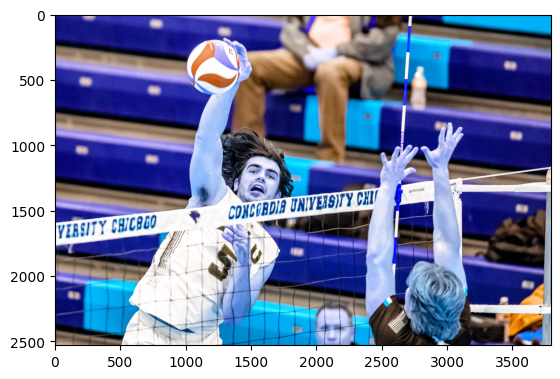

In [36]:
img = cv.imread("DATA/attack (123).jpg")
plt.imshow(img) #BGR

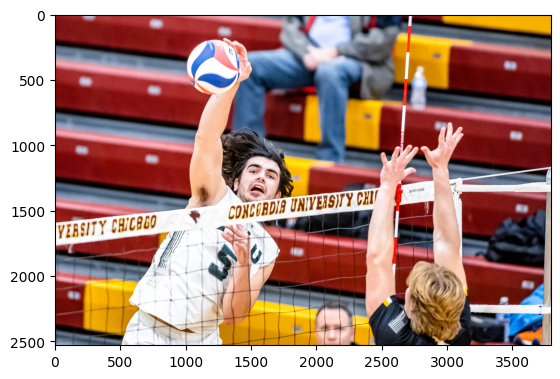

In [37]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [38]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('OpenPose using OpenCV', frame)

In [ ]:
#this keeps killing the kernal, DO NOT RUN this cell
estimated_image = pose_estimation(img)

In [ ]:
plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

# Conclusions, Future work:

In this notebook we loaded a dataset and some images by creating a custom dataset class of our own. From there i turned that dataset into two different dataloaders to train two different image classying networks. After seeing less than stellar results i decided to use a completely different architecture to see how much better it could perform. Unfortunaley the high resolution of my images seemed to be too much for jupyter to handle as trying to run it on one example caused the kernal to die repeatedly and unfortunaley i do not have time to research alternatives in the little time i have left in deep learning.


When it comes to what i have learned, it has been reiterated to me that any serious programming project is one that is going to take alot of testing and debugging to get right and this assignment definitly frustrated me at times. One of the most important things i learned is just how doable training your own nerual network can be and how it can truly be what ever you want it to be. As for more concrete topics learned from class, I discover just how important input normalization as it only serves to help the model perform better or in my case at all. Prior to normalization a majority of my images would throw errors saying they were not compatible.

I 100 percent want to continue down the road of pose estimation. With all the research i have done regarding it i am convinced that i can create something really cool and higher performing than simple image classification, given that time allows for it. This project has been a combination of the two most recurrent and intrusive things in my life that being volleyball and computer science. During season the two are almost always at odds though it is very cool to see an instance of the two coming together. As for concretely what i would plan for continuing this project is definiley collecting far more data so we don't get poor performance like i did using ResNet. Thankfully i have found numerous potential volleyball based datasets online that could be useful. Also finding a way to load data into pose estimation without the kernal dying. Once i get over that hump i feel like there'd be no stopping me.